# Group objects that behave in a similar way
### Assets that behave/trade in a similar way
- Volitility
- Price Return Behavior

In [40]:
# Silence Warnings
import warnings 
warnings.simplefilter(action="ignore" , category=FutureWarning)

In [41]:
# Fetch/Structure Data
import numpy as np 
import pandas as pd
import yfinance as yf
import pandas_datareader.nasdaq_trader as pdr


# Feature Engineering
from sklearn.preprocessing import  StandardScaler

# Machine Learning
from sklearn.cluster import  KMeans
from sklearn import metrics

# The knee point is the point of maximum curvature.
from kneed import KneeLocator

# Co-Integration and Statistics
from statsmodels.tsa.stattools import coint
import statsmodels.api as sm

# Reporting Visualization
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Data Extraction

In [42]:
# Data Storage
filename = "data-storage/raw_data_etf.csv"
filename_co_integration = "data-storage/raw_data_conint_pairs.csv"

In [43]:
# Load Saved Data or Fetch
load_existing = True
load_coint_pairs = False

In [44]:
# Time Range
start_date = "2023-01-01"
end_date = "2023-06-17"

### Fetch Data

In [45]:
#  Get New Data
if not load_existing:
    symbols = pdr.get_nasdaq_symbols()
    symbols = symbols[(symbols["ETF"] == True)  &  (symbols["Market Category"] == "G")] #global markets
    symbols = list(symbols.index.values)
    
    # # create dataframe with all etf stocks data
    fetched_stocks = []
    for symbol in symbols:
        data = yf.download(symbol ,  start_date , end_date )
        data = data[["Open" , "High" , "Low" , "Close" ]].copy()
        data["Symbol"] = symbol
        fetched_stocks.append(data)
    
    # Save Data
    df = pd.concat(fetched_stocks)
    df.reset_index(inplace=True)
    df = df.pivot(index='Date', columns='Symbol', values='Close')
    df.to_csv(filename)




# READ FILE
else:
    df = pd.read_csv(filename)

# Condition Data

In [46]:

# Drop Null Values
if df.isnull().values.any():
    df = df.dropna(axis=1)
    df = df.set_index("Date")

print("Shape: " , df.shape)
df.head()

Shape:  (866, 343)


,AADR,AAXJ,ACWI,ACWX,AGNG,AGZD,AIA,AIQ,AIRR,ALTY,...,VWOB,VXUS,VYMI,WBND,WCLD,WINC,WIZ,WOOD,XT,YLDE
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,54.860001,74.910004,80.070000,49.720001,23.665001,48.119999,67.459999,18.298000,28.822001,14.799,...,81.510002,56.310001,64.699997,94.771927,26.111000,25.834999,27.160000,66.820000,43.259998,33.209999
2020-01-03,54.570000,73.720001,79.379997,49.080002,23.555000,48.130001,66.209999,18.190001,29.115000,14.830,...,81.320000,55.619999,63.779999,94.912277,26.120001,25.834999,27.100000,66.269997,42.750000,32.930000
2020-01-06,54.349998,73.419998,79.559998,49.200001,23.565001,48.119999,66.230003,18.230000,29.013000,14.870,...,81.190002,55.700001,63.900002,94.912277,26.586000,25.879999,26.980000,66.150002,42.810001,32.856998
2020-01-07,54.430000,73.680000,79.360001,49.099998,23.650999,48.119999,66.430000,18.340000,28.969999,14.870,...,81.320000,55.599998,63.720001,94.666664,26.620001,25.879999,27.115000,66.120003,42.939999,32.759998
2020-01-08,54.480000,73.839996,79.750000,49.230000,23.763000,48.119999,66.830002,18.430000,28.945000,14.850,...,81.580002,55.700001,63.790001,94.701752,26.941000,25.879999,27.200001,66.120003,43.230000,32.939999


# Feature Engineering
- For Each ETF stock
    - average returns
    - average volitility


In [47]:
# Create Dataframe with Returns and Volitility for each stock

df_returns = pd.DataFrame(df.pct_change().mean() * 255 , columns=["Returns"])
df_returns["Volitility"] = df.pct_change().std() * np.sqrt(255)


df_returns

,Returns,Volitility
AADR,0.004054,0.270357
AAXJ,-0.001299,0.246897
ACWI,0.072782,0.229947
ACWX,0.020862,0.227489
AGNG,0.068536,0.209420
...,...,...
WINC,-0.027021,0.064515
WIZ,0.034050,0.221509
WOOD,0.063746,0.293513
XT,0.100530,0.258418


### Scaling Dataframe
- To make sure if one column ranges from 1 to 10 and another column ranges from 1000 to 10000

In [48]:
# Scaling Features
scaler = StandardScaler()

# Transform Values to propper scale size
scaler = scaler.fit_transform(df_returns)

# make a new dataframe using the scaled values
scaled_data = pd.DataFrame(scaler , columns=df_returns.columns , index=df_returns.index)
df_scaled = scaled_data


df_scaled

,Returns,Volitility
AADR,-0.387812,0.218875
AAXJ,-0.444363,0.020691
ACWI,0.338223,-0.122491
ACWX,-0.210261,-0.143257
AGNG,0.293370,-0.295897
...,...,...
WINC,-0.716086,-1.520005
WIZ,-0.070943,-0.193777
WOOD,0.242765,0.414491
XT,0.631349,0.118019


# K MEANS CLUSTERING

### Obtain Optimal Amount of Clusters
- how many clusters until the inertia dramatically decreases?

In [49]:
# Make a copy of your scaled dataframe
x = df_scaled.copy()

# Define amount of clusters
k = range(1,16,1)

# Create an empty list where we'll store the sum of squared distances
# (known as inertia) for each number of clusters
distortions = []

# Loop through each number of clusters in our range
for calc in k:
    # Create a KMeans model with the current number of clusters
    kmeans = KMeans(n_clusters=calc)
    
    # Fit the KMeans model to our data
    kmeans.fit(x)
    
    # Calculate the model's inertia (sum of squared distances to closest cluster)
    distortions.append(kmeans.inertia_)

# Use the KneeLocator function to find the "elbow point" in our range of clusters
# The elbow point is the number of clusters at which adding more clusters 
# does not significantly decrease the inertia (sum of squared distances).
# In this case, the function is looking for a point where the curve of the 
# distortions plot is convex and decreasing.
k1 = KneeLocator(k , distortions , curve="convex" , direction="decreasing")

# The elbow point (optimum number of clusters) is stored in `c`
Optimal_Amount_Clusters = k1.elbow

# Print out the optimum number of clusters
print("Optimum Clusters" , Optimal_Amount_Clusters)


Optimum Clusters 5


### Fit AI knn Model

In [50]:
# fit
k_means = KMeans(n_clusters=Optimal_Amount_Clusters)
k_means.fit(x)

KMeans(n_clusters=5)

In [51]:
# predict
prediction = k_means.predict(df_scaled)

# Display Results

<function matplotlib.pyplot.show(close=None, block=None)>

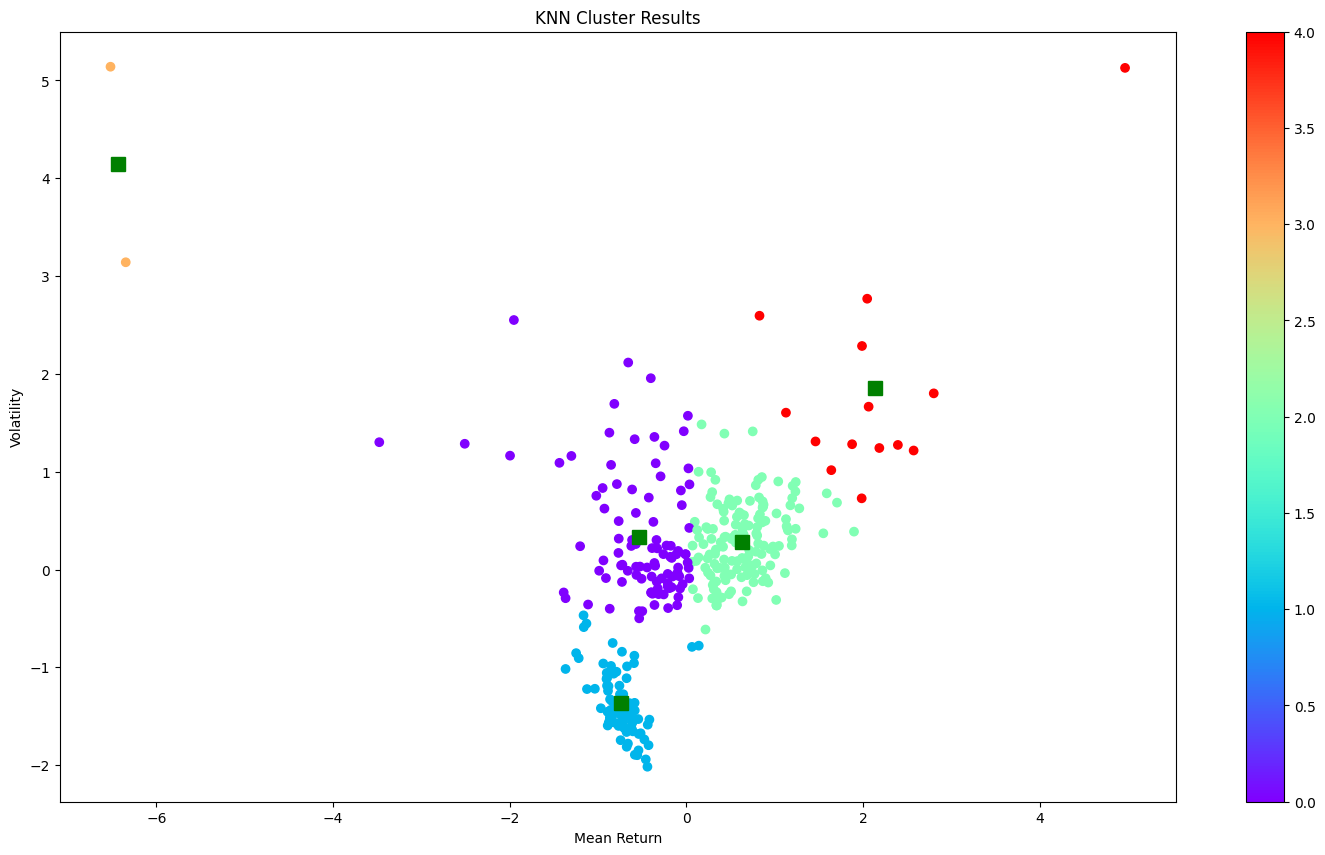

In [52]:
# Obtain the centroids of the clusters from the trained KMeans model.
centroids = k_means.cluster_centers_

# Create a figure to host the plot, with size 18x10.
fig = plt.figure(figsize=(18,10))

# Add a subplot to the figure.
Graphic = fig.add_subplot(111)

# Scatter plot of the data, colored by cluster label.
scatter = Graphic.scatter(x.iloc[:,0], x.iloc[:,1] , c = k_means.labels_, cmap="rainbow" , label=x.index)

# Set the title and labels for the axes of the plot.
Graphic.set_title("KNN Cluster Results")
Graphic.set_xlabel("Mean Return")
Graphic.set_ylabel("Volatility")

# Display a color bar to illustrate which color corresponds to which cluster.
plt.colorbar(scatter)

# Plot the centroids of each cluster as green squares.
plt.plot(centroids[:,0] , centroids[:,1] , "sg" , markersize = 10)
plt.show


In [53]:
# Return Series
clustered_series = pd.Series(index=x.index , data=k_means.labels_.flatten())
clustered_series_all = pd.Series(index=x.index , data=k_means.labels_.flatten())

# Remove outliers, denoted by -1, from the series
clustered_series = clustered_series[clustered_series != -1]


clustered_series[:15]

AADR    0
AAXJ    0
ACWI    2
ACWX    0
AGNG    2
AGZD    1
AIA     0
AIQ     2
AIRR    4
ALTY    0
ANGL    1
ASET    0
BBH     2
BFIT    0
BGRN    1
dtype: int32

Text(0.5, 0, 'Cluster')

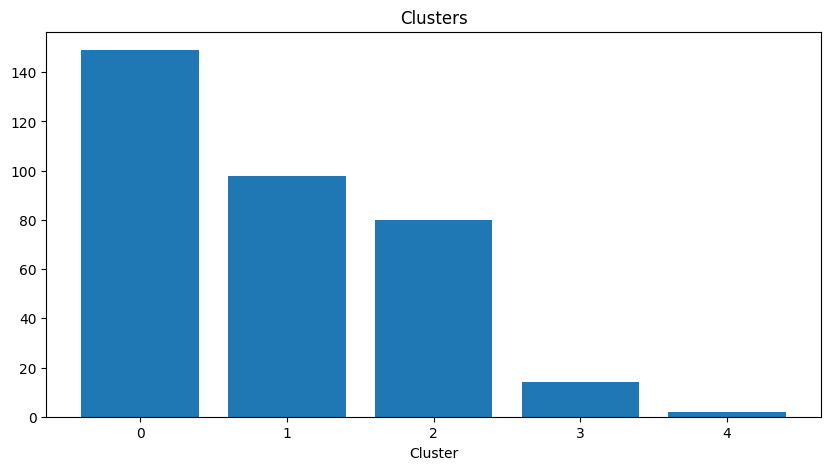

In [54]:
# view number by cluser
plt.figure(figsize=(10,5))

# Generate a bar chart. X-axis is the range of the number of unique clusters. Y-axis is the count of items in each cluster.
plt.bar(range(len(clustered_series.value_counts())) , clustered_series.value_counts())

# Labels
plt.title("Clusters")
plt.xlabel("Cluster")

In [55]:
# Remove Clusters if preferred
clusters_clean = clustered_series[clustered_series < 3]

print(f"Current Clusters: {len(clustered_series)}")
print(f"Cleaned Clusters: {len(clusters_clean)}")

Current Clusters: 343
Cleaned Clusters: 327
